# This File is for Testing (not user facing)

### **Imports**

In [8]:
# Environment
import os
import time
from rlkit.envs import UnityEnv, registered_env_list
from rlkit.envs.env_utils import create_unity_env

# Algorithms
from rlkit.templates import PPOBasic, PPOTrainConfig, PPOState, ppo_log_keys
from rlkit.modules import ActorValueInverseOperator, ClipPPOInverseLoss
from runners.ppo import create_policy, create_loss_module
from torch import nn, optim

# Models
import torch
from torchrl.modules import ActorValueOperator, ValueOperator, ActorCriticWrapper
from rlkit.models import MLP
from tensordict.nn import TensorDictModule
from rlkit.models import ConditionalCNN, CondVisionFeatureModel

# Utility
from tensordict import TensorDict
import pandas as pd
from dataclasses import asdict
import matplotlib.pyplot as plt
from rlkit.utils import SimpleMetricModule, LoggerBase, TensorBoardLogger, plot_results, create_animation, hf_hub_download_and_copy, HFTBLogger
from utils import ppo_load_config, PPOAgent
from torchinfo import summary
from utils import get_repo_tree

print(f"Avaliable Environments: {registered_env_list}")

Avaliable Environments: ['Crawler', 'PushBlock', '3DBall', 'Walker', 'WallJump', 'Worm', 'GridWorld']


In [9]:
ENV_NAME = 'GridWorld'
ENV_PATH = os.path.join("built_envs", f"{ENV_NAME}.app")

### **Transform Environment**

In [3]:
env = UnityEnv(name=ENV_NAME, graphics=True)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'discrete_action' is unaccounted for by the transform (expected keys ['RenderTextureSensor', 'VectorlSensor', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


In [4]:
data = env.rollout(100, break_when_any_done=False)

/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/torch/nested/__init__.py:250: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:182.)
  return _nested.nested_tensor(


In [5]:
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([9, 100, 5]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([9, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        indicator: Tensor(shape=torch.Size([9, 100, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([9, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                indicator: Tensor(shape=torch.Size([9, 100, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([9, 100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([9, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([9, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                visual_observation: Tensor(shape=to

In [6]:
from IPython.display import HTML

imgs = data[0]['visual_observation'].permute(0, 2, 3, 1).detach().cpu().numpy()
ani = create_animation(imgs)
HTML(ani.to_jshtml())

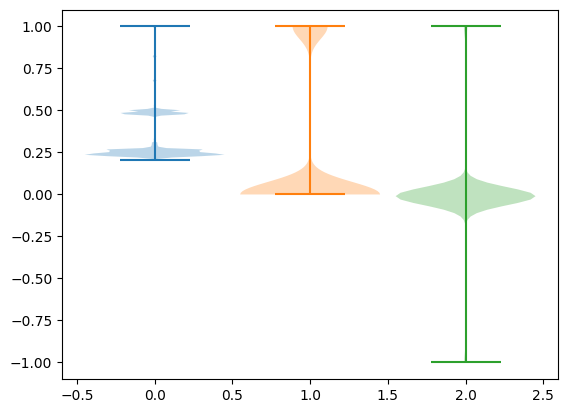

In [7]:
obs_df = pd.DataFrame(data["visual_observation"].reshape(-1))
act_df = pd.DataFrame(data["action"].reshape(-1))
rew_df = pd.DataFrame(data["next", "reward"].reshape(-1))

for i, df in enumerate([obs_df, act_df, rew_df]):
    plt.violinplot(df, positions=[i], widths=0.9)

## **PPO**

### **Env Config**

### **Config**

In [10]:
action_dim = env.action_spec.shape[-1]
obs_shape = list(env.observation_spec["visual_observation"].shape[-3:])

# PPO
ppo_algo_config = {
    "epsilon": 0.2,
    "entropy_coef": 1e-3,
    "gamma": 0.99,
    "lmbda": 0.95,
    "value_coef": 10,
}

# Model
# model_config = {
#     "in_features": obs_dim,
#     "out_features": action_dim,
#     "n_blocks": 2,
#     "hidden_dim": 32,
# }
cnn_config = {
    "in_channels": 3,
    "out_dim": 64,
    "time_dim": 2,
    "depths": [1, 1],
    "dims": [16, 32]
}

model_config = {
    "in_features": 64,
    "out_features": action_dim,
    "n_blocks": 1,
    "hidden_dim": 16,
}

# Training
config = PPOTrainConfig(
    generations=100,
    generation_size=100_000,
    slice_len=128,
    n_slices=2048,
    epochs=20,
    minibatch_size=256,

    workers=10,
    env_batch_dim=1,

    kl_soft_clip=0.02,
    early_stop_threshold=8,
    kl_hard_clip=0.05,

    start_generation=0,
)
LR = 1e-5

cnn_config, model_config, obs_shape

({'in_channels': 3,
  'out_dim': 64,
  'time_dim': 2,
  'depths': [1, 1],
  'dims': [16, 32]},
 {'in_features': 64, 'out_features': 5, 'n_blocks': 1, 'hidden_dim': 16},
 [3, 64, 84])

In [11]:
cnn_model = ConditionalCNN(**cnn_config)
summary(cnn_model, input_size=[(1, *obs_shape), (1, 2)])

Layer (type:depth-idx)                   Output Shape              Param #
ConditionalCNN                           [1, 64]                   --
├─Sequential: 1-1                        [1, 16, 16, 21]           --
│    └─Conv2d: 2-1                       [1, 16, 16, 21]           784
│    └─LayerNorm2d: 2-2                  [1, 16, 16, 21]           32
├─Sequential: 1-2                        [1, 32]                   --
│    └─Linear: 2-3                       [1, 32]                   64
│    └─MLPBlock: 2-4                     [1, 32]                   --
│    │    └─RMSNorm: 3-1                 [1, 32]                   32
│    │    └─GatedLinear: 3-2             [1, 85]                   5,440
│    │    └─Linear: 3-3                  [1, 32]                   2,720
├─ModuleList: 1-5                        --                        (recursive)
│    └─ModuleList: 2-5                   --                        --
│    │    └─CondCXBlock: 3-4             [1, 16, 16, 21]           4,

### **State**

In [12]:
action_type = 'discrete'
in_keys = ['visual_observation', 'indicator']

# Trunk
cnn_model = ConditionalCNN(**cnn_config)
trunk = TensorDictModule(cnn_model, in_keys=in_keys, out_keys=["hidden_features"])

# Policy
policy_config = model_config.copy()
if action_type == 'continuous':
    policy_config["out_features"] *= 2      
policy_base = MLP(**policy_config)
policy = create_policy(policy_base, policy_type=action_type, in_keys=["hidden_features"])

# Value
value_config = model_config.copy()
value_config["out_features"] = 1
value_base = MLP(**value_config)
value = ValueOperator(value_base, in_keys=["hidden_features"])

# Inverse Dynamics
inverse_config = model_config.copy()
inverse_config["in_features"] *= 2
inverse_base = MLP(**inverse_config)
inverse = TensorDictModule(inverse_base, in_keys=["hidden_features", "next_hidden_features"], out_keys=[""])

# Loss Module
loss_module = create_loss_module(policy, value, **ppo_algo_config)

# Optimizer
optimizer = optim.Adam(loss_module.parameters(), lr=LR)

# Logger
logger = TensorBoardLogger(ppo_log_keys, log_dir='temp/logs') # LoggerBase(ppo_log_keys)
logger.reset()

model = ActorValueInverseOperator(
    common_operator=trunk,
    policy_operator=policy,
    value_operator=value,
    inverse_operator=inverse,
)

# State
state = PPOState(
    model=model,
    optimizer=optimizer,
    loss_module=loss_module,

    logger=logger,
)

In [13]:
model.get_policy_operator()(TensorDict({
    "visual_observation": torch.randn(1, *obs_shape),
    "indicator": torch.randn(1, 2),
}))

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1, 5]), device=cpu, dtype=torch.int64, is_shared=False),
        hidden_features: Tensor(shape=torch.Size([1, 64]), device=cpu, dtype=torch.float32, is_shared=False),
        indicator: Tensor(shape=torch.Size([1, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        log_prob: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        logits: Tensor(shape=torch.Size([1, 5]), device=cpu, dtype=torch.float32, is_shared=False),
        visual_observation: Tensor(shape=torch.Size([1, 3, 64, 84]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

In [25]:
with torch.no_grad():
    data = env.rollout(10, policy=model.get_policy_operator(), break_when_any_done=False)
    loss_module.value_estimator(data)
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([9, 10, 5]), device=cpu, dtype=torch.int64, is_shared=False),
        advantage: Tensor(shape=torch.Size([9, 10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([9, 10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        hidden_features: Tensor(shape=torch.Size([9, 10, 64]), device=cpu, dtype=torch.float32, is_shared=False),
        indicator: Tensor(shape=torch.Size([9, 10, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        log_prob: Tensor(shape=torch.Size([9, 10]), device=cpu, dtype=torch.float32, is_shared=False),
        logits: Tensor(shape=torch.Size([9, 10, 5]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([9, 10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                indicator: Tensor(shape=torch.Size([9, 10, 2]), device=cpu, dtype=tor

In [17]:
loss_data = loss_module(data)
loss_data

TensorDict(
    fields={
        ESS: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        clip_fraction: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        entropy: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        explained_variance: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        kl_approx: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        loss_critic: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        loss_entropy: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        loss_objective: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

In [20]:
loss = sum(v.mean() for k, v in loss_data.items() if k.startswith("loss_"))
loss

tensor(0.1785, grad_fn=<AddBackward0>)

In [9]:
env.close()

### **PPO**

In [10]:
ppo = PPOBasic(lambda: UnityEnv(ENV_NAME, ENV_PATH, graphics=True), ppo_config=config, ppo_state=state, verbose=True)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [11]:
ppo.run()

[1/100] Starting Generation


/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[1/100] Collected Data in 38.61830496788025
2026-01-02 14:07:40,260 [torchrl][WARNING]    Got a tensordict without a time-marked dimension, assuming time is along the last dimension. This warning can be turned off by setting the environment variable RL_WARNINGS to False. [END]
2026-01-02 14:08:06,376 [torchrl][WARNING]    Got a tensordict without a time-marked dimension, assuming time is along the last dimension. This warning can be turned off by setting the environment variable RL_WARNINGS to False. [END]
Early stopped at (5, 99)
[1/100] Trained in 16.270954608917236
   timestep  generation       time  collection_time  train_time    return  \
0    100000           1  85.953187        38.618305   16.270955 -0.459342   

   episode_length   entropy  policy_loss  kl_approx  clip_fraction       ESS  \
0       44.876509  1.495674     0.001941    0.00563            0.0  0.988202   

   value_loss  explained_variance  
0     0.04535            0.000021  
[2/100] Starting Generation
[2/100] C

Process _ProcessNoWarn-7:
Process _ProcessNoWarn-8:
Process _ProcessNoWarn-9:
Process _ProcessNoWarn-10:
Process _ProcessNoWarn-6:
Process _ProcessNoWarn-1:
Process _ProcessNoWarn-4:
Process _ProcessNoWarn-5:
Process _ProcessNoWarn-2:
Process _ProcessNoWarn-3:
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/torchrl/_utils.py", line 594, in run
    return mp.Process.run(self, *args, **kwargs)
  File "/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/torchrl/collectors/collectors.py", line 3634, in _main_async_collector
    if not run_free and pipe_child.poll(_timeout):
  File "/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/mul

KeyboardInterrupt: 

In [ ]:
ppo.close()

### **Plot Results**

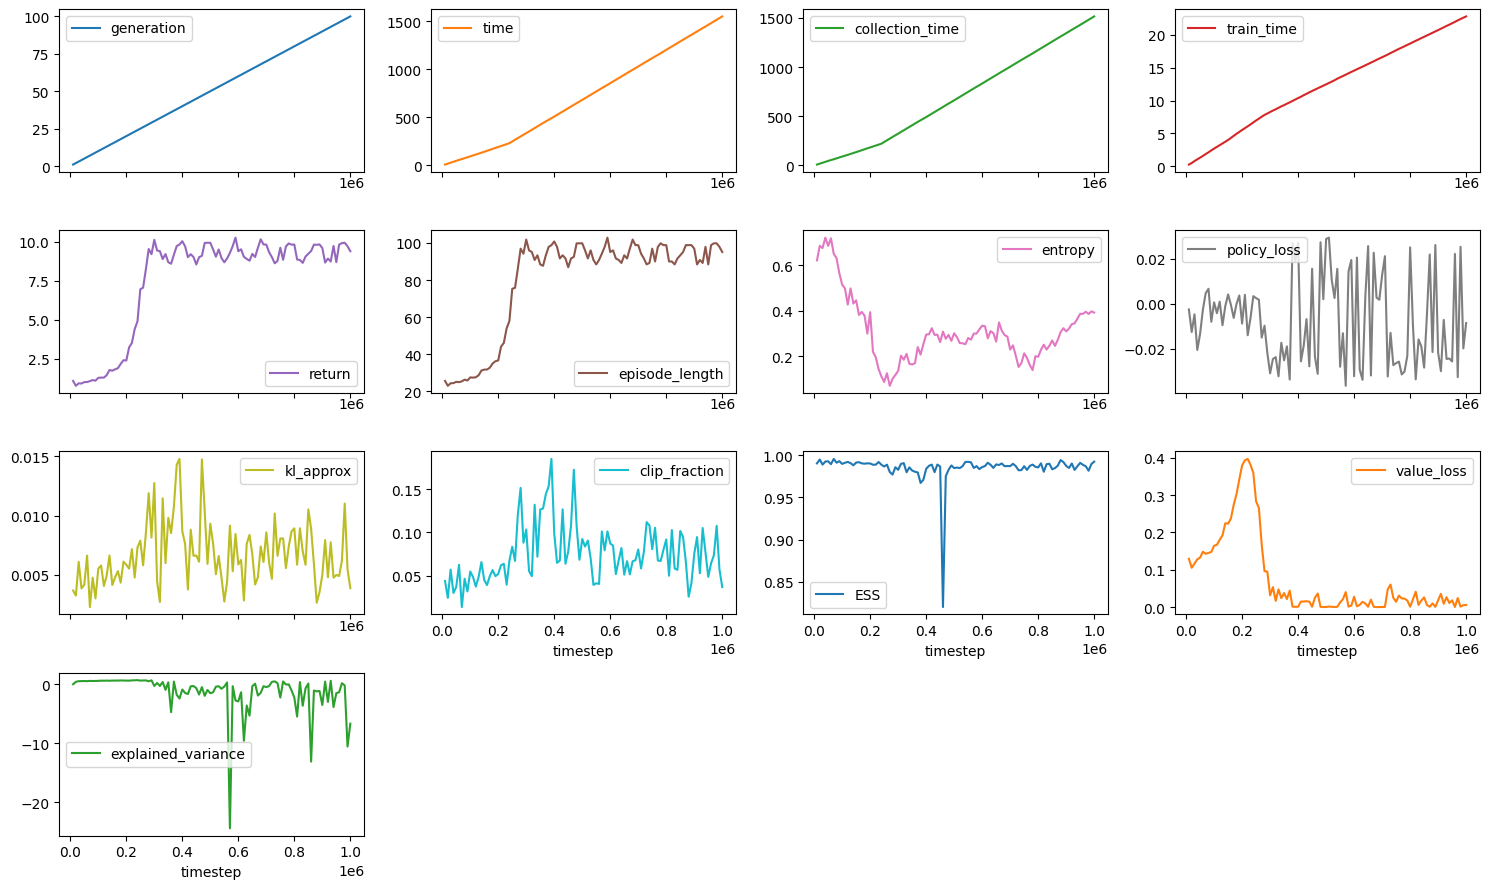

In [ ]:
LOG_INDEX = "timestep"
def plot():
    df = logger.dataframe()
    df = df.set_index(LOG_INDEX)

    rows = (len(df.columns) + 3) // 4
    df.plot(subplots=True, layout=(rows,4), figsize=(15, int(rows* 7/3)))
    plt.tight_layout()
    plt.show()
plot()

## **SAC**

## **Evaluate Agent**

In [ ]:
# log_path = "experiments/Walker/ppo/conf1/logs/run2"
# logger = HFTBLogger(ppo_log_keys, log_dir=log_path, repo_id='notnotDroid/unity-rl', repo_subfolder=log_path)
# logger.sync_from_hub()

/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `snapshot_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
Fetching 2 files: 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


In [7]:
log_path = os.path.join("experiments", ENV_NAME, "ppo", "conf1", "logs", "run9")
log_keys = tb_get_keys(log_path)
log_keys

['timestep',
 'generation',
 'time',
 'collection_time',
 'train_time',
 'return',
 'episode_length',
 'entropy',
 'policy_loss',
 'kl_approx',
 'clip_fraction',
 'ESS',
 'value_loss',
 'explained_variance',
 'lr']

In [8]:
logger = TensorBoardLogger(log_keys, log_dir=log_path)
logger.revert()
df = logger.dataframe()
df

,timestep,generation,time,collection_time,train_time,return,episode_length,entropy,policy_loss,kl_approx,clip_fraction,ESS,value_loss,explained_variance,lr
0,80000.0,1.0,19.755331,9.165974,8.862488,-0.094054,15.119335,6.468812,-0.002263,0.000093,0.0,0.99983,0.046399,-21.309109,0.0
1,160000.0,2.0,38.447533,17.757206,17.4009,-0.093854,15.582665,6.535958,-0.003588,0.005543,0.047369,0.990302,0.009053,-3.521789,0.000002
2,240000.0,3.0,57.515495,26.295513,26.333296,-0.093247,15.832081,6.75158,-0.017391,0.00674,0.066181,0.988148,0.00295,-2.757794,0.000004
3,320000.0,4.0,78.391037,35.616055,35.953709,-0.091801,15.946856,6.914603,-0.009124,0.006765,0.092284,0.985931,0.001579,-0.993868,0.000006
4,400000.0,5.0,97.733101,44.311306,45.052345,-0.091191,16.358252,7.086745,-0.023846,0.008526,0.107561,0.98448,0.000977,-0.312968,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,399680000.0,4996.0,141624.109375,86235.367188,52504.71875,163.208649,500.0,6.572702,-0.006723,0.0,0.0,1.0,0.284054,0.970748,0.0
4996,399760000.0,4997.0,141651.828125,86252.28125,52514.949219,166.98671,494.444458,7.304282,-0.011079,-0.0,0.0,1.0,0.301221,0.95579,0.0
4997,399840000.0,4998.0,141679.578125,86269.429688,52525.0,164.679871,497.538879,7.405424,-0.001864,-0.0,0.0,1.0,0.291449,0.963228,0.0
4998,399920000.0,4999.0,141707.53125,86286.359375,52535.464844,169.088516,503.274017,7.344433,-0.006691,-0.0,0.0,1.0,0.2754,0.964807,0.0


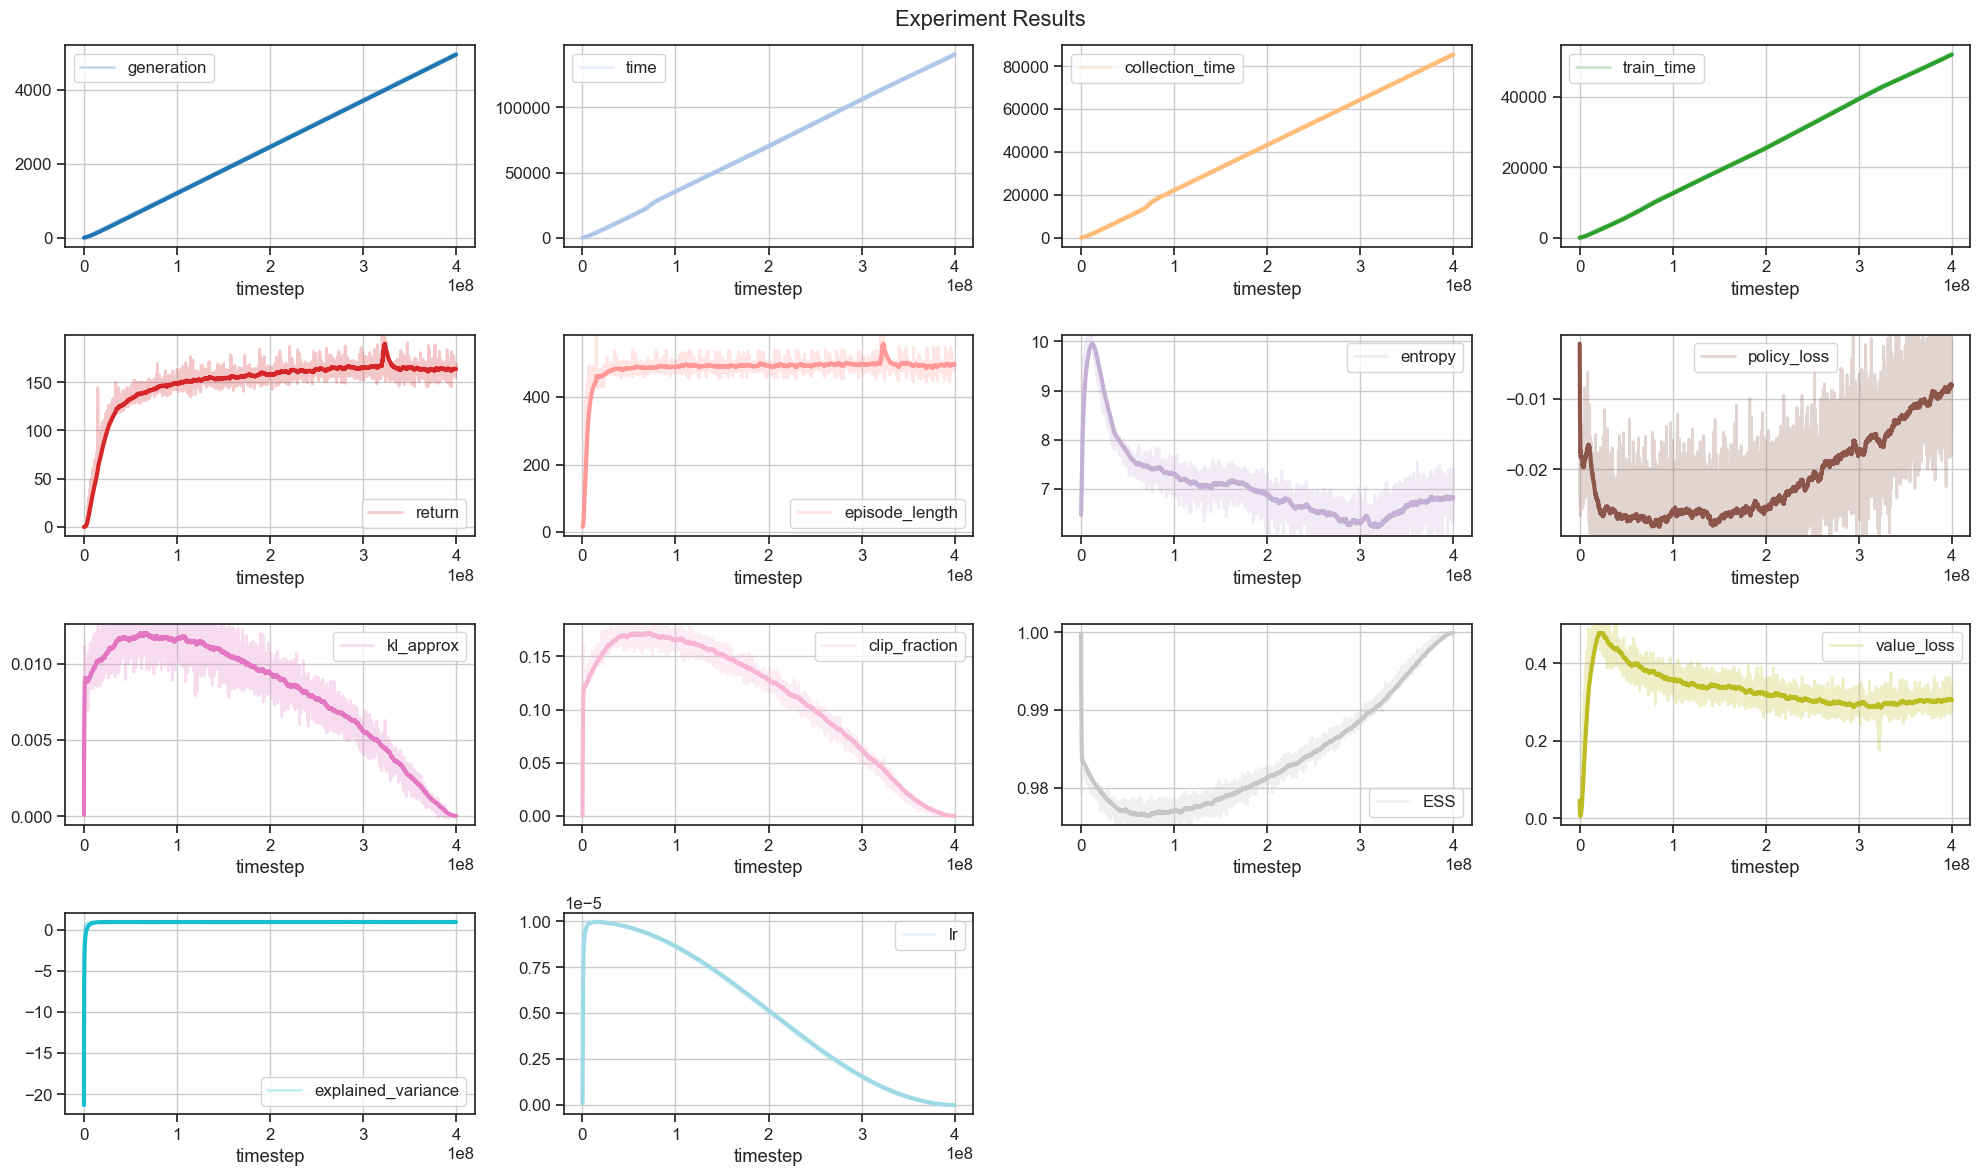

In [9]:
plot_results(df, log_index='timestep', ewma_span=100)

In [19]:
model = PPOAgent(ENV_NAME, 'conf1', 'run3_latest', save_type='ckpts', lkwargs={'weights_only': False}, no_cache=True)
# model = PPOAgent(ENV_NAME, 'conf1', 'run2')
policy = model.get_policy_operator()

In [20]:
try: env.close()
except: pass

env = UnityEnv(name=ENV_NAME, path=ENV_PATH, graphics=False, time_scale=20)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'continuous_action' is unaccounted for by the transform (expected keys ['VectorSensor_size243', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


In [21]:
data = None
with torch.no_grad():
    data = env.rollout(10_000, policy=policy, break_when_any_done=False)

ERROR: Shader UI/Default shader is not supported on this GPU (none of subshaders/fallbacks are suitable)


In [18]:
print(data)

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 10000, 39]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 10000, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([10, 10000, 39]), device=cpu, dtype=torch.float32, is_shared=False),
        log_prob: Tensor(shape=torch.Size([10, 10000]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 10000, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([10, 10000, 243]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([10, 10000, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([10, 10000, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(sh

In [17]:
try: env.close()
except: pass

SimpleMetricModule(mode="approx")(data)

{'return': 21.21980857849121,
 'episode_length': 970.873779296875,
 'entropy': 20.240005493164062}

In [12]:
from mlagents_envs.registry import default_registry

environment_names = list(default_registry.keys())
environment_names

['Basic',
 '3DBall',
 '3DBallHard',
 'Crawler',
 'DungeonEscape',
 'FoodCollector',
 'GridWorld',
 'Hallway',
 'PushBlock',
 'Pyramids',
 'SoccerTwos',
 'Sorter',
 'StrikersVsGoalie',
 'VisualFoodCollector',
 'WallJump',
 'Walker',
 'Worm']